# AMZN_stock_analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN.csv' #데이터 선택
#데이터 시작점은 max, 2008년 중 2008년으로 선택.

df1 = pd.read_csv(dataset_filepath) #데이터 소환 명령어 지정 df
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) #데이터 index를 'Date'로 지정
ts1 = df1['Close'] #Close를 데이터 벨류로 지정. -> pandas 데이터를 time series(data가 time index 에 따라 나열.)로 변환 완료.


ts1.head()

Date
2008-01-02    96.250000
2008-01-03    95.209999
2008-01-04    88.790001
2008-01-07    88.820000
2008-01-08    87.879997
Name: Close, dtype: float64

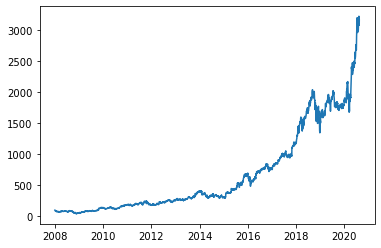

In [2]:
# 결측치 처리
ts1=ts1.interpolate(method='time')

ts1[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
plt.plot(ts1) #데이터 확인

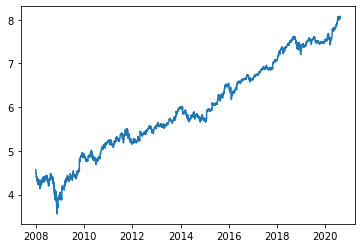

In [3]:
# 로그 변환
# [[YOUR CODE]]
ts1_log = np.log(ts1) #로그 변환
plt.plot(ts1_log) #변환된 데이터 보기

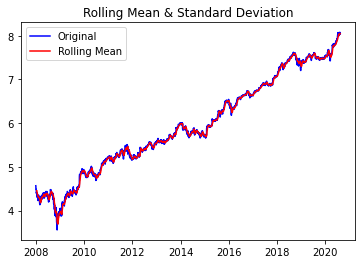

Results of Dickey-Fuller Test:
Test Statistic                    0.329684
p-value                           0.978666
#Lags Used                        2.000000
Number of Observations Used    3173.000000
Critical Value (1%)              -3.432413
Critical Value (5%)              -2.862451
Critical Value (10%)             -2.567255
dtype: float64


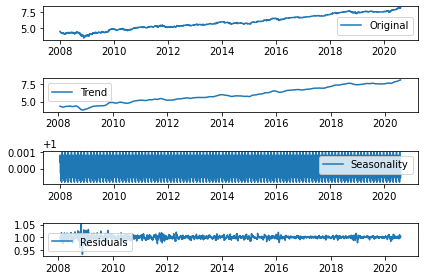

In [4]:
from statsmodels.tsa.stattools import adfuller


def plot_rolling_statistics(timeseries, window=12):  # rolling 함수 정의
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
   # std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

def augmented_dickey_fuller_test(timeseries): # adft 함수 정의
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)    

# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition1 = seasonal_decompose(ts1_log, model='multiplicative', period = 30)  #model 선택 이유는?
# [[YOUR CODE]]

trend1 = decomposition1.trend
seasonal1 = decomposition1.seasonal
residual1 = decomposition1.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [5]:
# Residual 안정성 확인
# [[YOUR CODE]]

#plot_rolling_statistics(residual) #6-6에서 window 안한 이유는? -> 저 위에서 함.

residual1.dropna(inplace=True) #window 값 지정을 안 했는데 왜 na값이 생겼지? -> 맨 위 코드에서 12로 지정.
augmented_dickey_fuller_test(residual1)

Results of Dickey-Fuller Test:
Test Statistic                -1.491400e+01
p-value                        1.444316e-27
#Lags Used                     2.800000e+01
Number of Observations Used    3.117000e+03
Critical Value (1%)           -3.432450e+00
Critical Value (5%)           -2.862468e+00
Critical Value (10%)          -2.567264e+00
dtype: float64


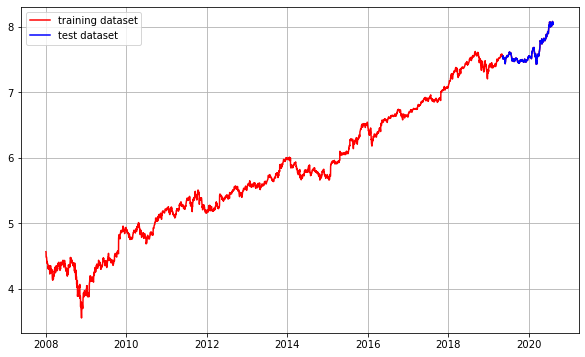

In [6]:
train1_data, test1_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
#[0에서 총수의 0.9배수까지], [0.9배수에서 끝까지]
# [[YOUR CODE]]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test1_data, c='b', label='test dataset')
plt.legend()

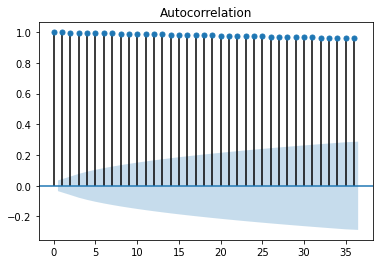

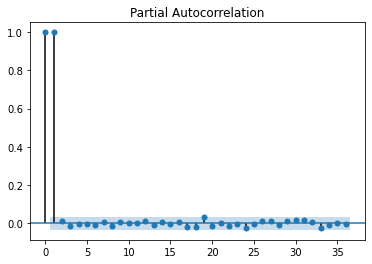

In [7]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# [[YOUR CODE]]
plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기 -> 여기서 p=1 + AR(p=1)모델 선택
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -42.238531
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    3173.000000
Critical Value (1%)              -3.432413
Critical Value (5%)              -2.862451
Critical Value (10%)             -2.567255
dtype: float64


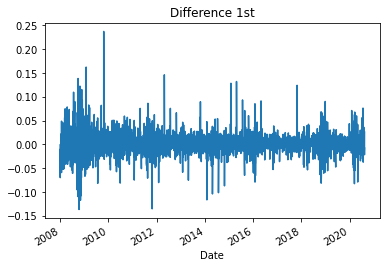

In [8]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1) #p-value 1.340952e-25

# 2차 차분 구하기

# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2) #p-value는 똑같이 0 -> d = 1로 결정

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2857
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6636.220
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 13 Aug 2020   AIC                         -13264.441
Time:                        17:29:43   BIC                         -13240.611
Sample:                             1   HQIC                        -13255.848
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011   6.63e-05     17.329      0.000       0.001       0.001
ar.L1.D.Close     0.9929      0.003    386.577      0.000       0.988       0.998
ma.L1.D.Close    -1.0000      0.001   -8

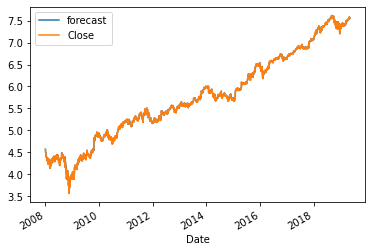

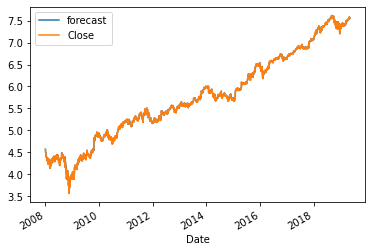

In [9]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]

model1 = ARIMA(train1_data, order=(1, 1, 1))  #(p,d,q) p=1, d=1. q는 가장 MAPE값이 낮은 1과 8 중 1 을선택
fitted_m = model1.fit(disp=-1)  
print(fitted_m.summary())
fitted_m.plot_predict() #그래프로 확인

#0-19.92 13.92
#1-10.79
#2-13.97
#3-11.12
#4-19.85 11.07
#5-11.15
#6-11.13
#7-11.14
#8-19.81 10.99
#9-11.06
#10-11.07
#11-14.14
#12-19.78 11.25

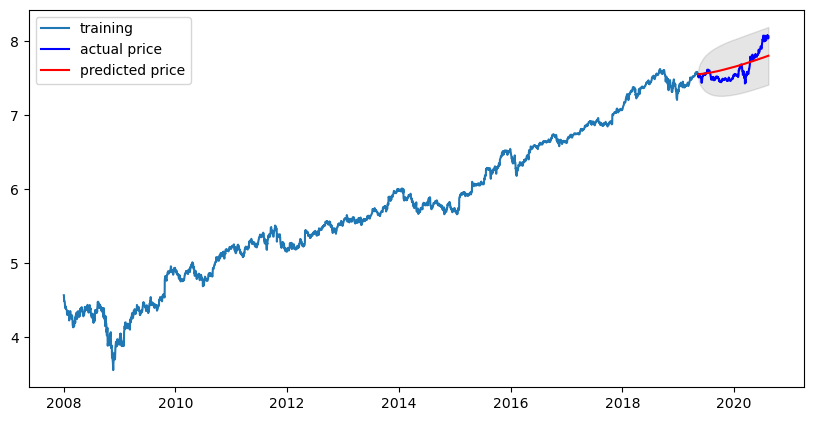

In [10]:
# Forecast : 결과가 fc에 담깁니다. 
fc1, se1, conf1 = fitted_m.forecast(len(test1_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc1_series = pd.Series(fc1, index=test1_data.index)   # 예측결과
lower1_series = pd.Series(conf1[:, 0], index=test1_data.index)  # 예측결과의 하한 바운드
upper1_series = pd.Series(conf1[:, 1], index=test1_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train1_data, label='training')
plt.plot(test1_data, c='b', label='actual price')
plt.plot(fc1_series, c='r',label='predicted price')
plt.fill_between(lower1_series.index, lower1_series, upper1_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test1_data), np.exp(fc1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test1_data), np.exp(fc1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test1_data), np.exp(fc1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc1) - np.exp(test1_data))/np.abs(np.exp(test1_data)))
print('MAPE: {:.2f}%'.format(mape*100))

#0-19.92 13.92 15.68
#1-      10.79 15.66
#2-      13.97 15.73
#3-      11.12 15.65
#4-19.85 11.07 15.72
#5-      11.15 15.73
#6-      11.13 15.74
#7-      11.14 15.73
#8-19.81 10.99 15.71
#9-      11.06 15.8
#10-      11.07 15.70
#11-      14.14 15.70
#12-19.78 11.25 15.69

MSE:  85468.87252319342
MAE:  231.22827901160412
RMSE:  292.3505986366257
MAPE: 10.79%


# GOOG_stock_analysis

In [12]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv' #데이터 선택

df2 = pd.read_csv(dataset_filepath) #데이터 소환 명령어 지정 df
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) #데이터 index를 'Date'로 지정
ts2 = df2['Close'] #Close를 데이터 벨류로 지정. -> pandas 데이터를 time series(data가 time index 에 따라 나열.)로 변환 완료.


ts2.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
Name: Close, dtype: float64

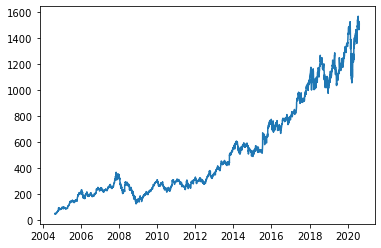

In [13]:
# 결측치 처리
ts2=ts2.interpolate(method='time')

ts2[ts2.isna()]
plt.plot(ts2) #데이터 확인

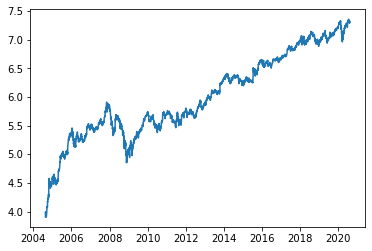

In [14]:
# 로그 변환
ts2_log = np.log(ts2) #로그 변환
plt.plot(ts2_log) #변환된 데이터 보기

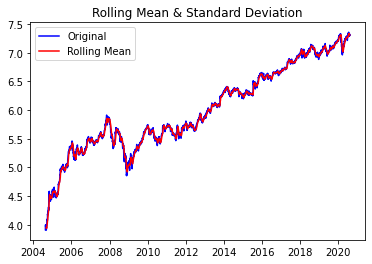

Results of Dickey-Fuller Test:
Test Statistic                   -2.296705
p-value                           0.173033
#Lags Used                       12.000000
Number of Observations Used    4011.000000
Critical Value (1%)              -3.431981
Critical Value (5%)              -2.862261
Critical Value (10%)             -2.567154
dtype: float64


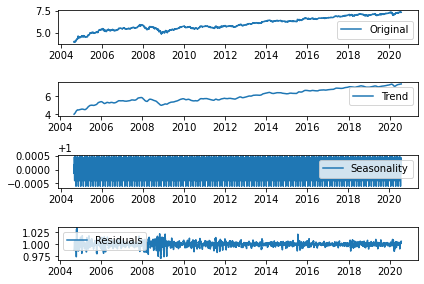

In [15]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(ts2_log, model='multiplicative', period = 30)  #model 선택 이유는?

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [16]:
# Residual 안정성 확인

residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                -1.465120e+01
p-value                        3.498179e-27
#Lags Used                     3.000000e+01
Number of Observations Used    3.963000e+03
Critical Value (1%)           -3.432001e+00
Critical Value (5%)           -2.862270e+00
Critical Value (10%)          -2.567158e+00
dtype: float64


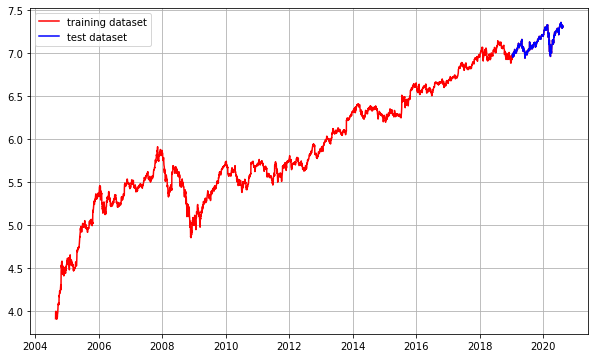

In [17]:
train2_data, test2_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]

#tain2, test2 데이터 확인

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')
plt.plot(test2_data, c='b', label='test dataset')
plt.legend()

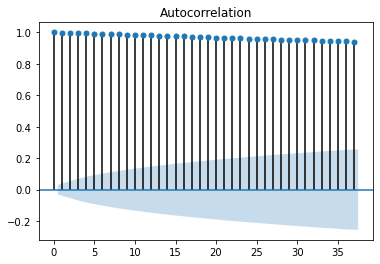

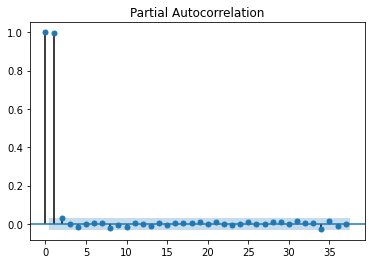

In [18]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts2_log) #ACF
plot_pacf(ts2_log) #PACF
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.760902e+01
p-value                        3.887867e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.011000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862261e+00
Critical Value (10%)          -2.567154e+00
dtype: float64


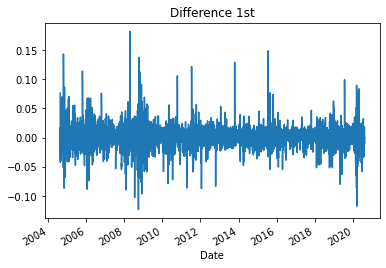

In [19]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1) #p-value 3.887867e-30 -> d = 1

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3620
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9211.049
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                         -18416.097
Time:                        17:29:44   BIC                         -18397.515
Sample:                             1   HQIC                        -18409.477
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.656      0.008       0.000       0.001
ar.L1.D.Close     0.0087      0.017      0.522      0.602      -0.024       0.041
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


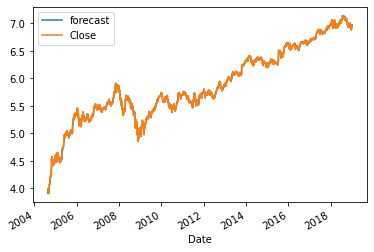

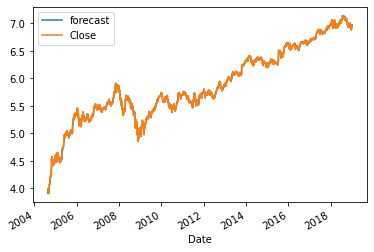

In [20]:
model2 = ARIMA(train2_data, order=(1, 1, 0))  #(p,d,q) p=1, d=1. q값에 따른 큰 차이 없으므로 0으로 선택
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())
fitted_m2.plot_predict() #그래프로 확인

#q값에 따른 MAPE값
#0-5.04
#1-
#2-
#3-
#4-5.04
#5-
#6-
#7-
#8-5.05
#9-
#10-
#11-
#12-5.05

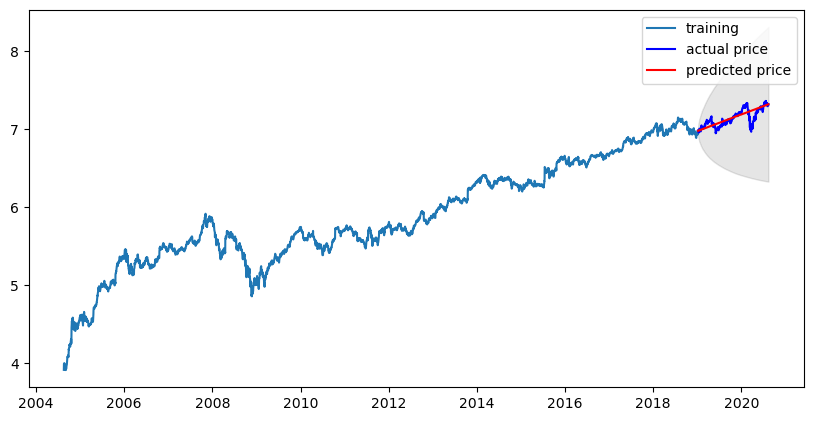

In [21]:
# Forecast : 결과가 fc에 담깁니다. 
fc2, se2, conf2 = fitted_m2.forecast(len(test2_data), alpha=0.01)  # 99% conf

# Make as pandas series

fc2_series = pd.Series(fc2, index=test2_data.index)   # 예측결과
lower2_series = pd.Series(conf2[:, 0], index=test2_data.index)  # 예측결과의 하한 바운드
upper2_series = pd.Series(conf2[:, 1], index=test2_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train2_data, label='training')
plt.plot(test2_data, c='b', label='actual price')
plt.plot(fc2_series, c='r',label='predicted price')
plt.fill_between(lower2_series.index, lower2_series, upper2_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [22]:
mse = mean_squared_error(np.exp(test2_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test2_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test2_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2) - np.exp(test2_data))/np.abs(np.exp(test2_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7697.223371738794
MAE:  62.38887827130351
RMSE:  87.73382113950579
MAPE: 5.04%


# LMT_stock_analysis

In [23]:
# Time Series 생성

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/LMT.csv' #데이터 선택

df3 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) #데이터 index를 'Date'로 지정
ts3 = df3['Close'] #Close를 데이터 벨류로 지정. -> pandas 데이터를 time series(data가 time index 에 따라 나열.)로 변환 완료.


ts3.head()

Date
1977-01-03    0.958589
1977-01-04    0.958589
1977-01-05    0.984151
1977-01-06    1.035276
1977-01-07    1.048057
Name: Close, dtype: float64

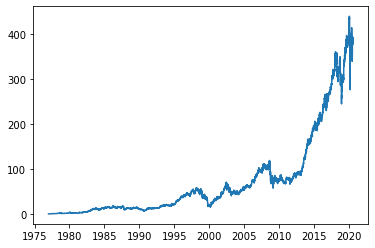

In [24]:
# 결측치 처리
ts3 = ts3.interpolate(method='time')

ts3[ts3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
plt.plot(ts3) #데이터 확인

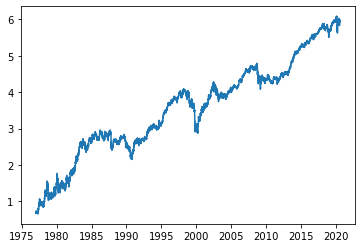

In [25]:
# 로그 변환

ts3_log = np.log(ts3+1) #로그 변환 1970년대 주가가 1달러 미만인 센트 단위를 가졌기에 달러로 환산하면 소수점 이하로 표시되고 이를 다시 로그를 통해 변환하면 음수를 갖는다.
plt.plot(ts3_log) #변환된 데이터 보기

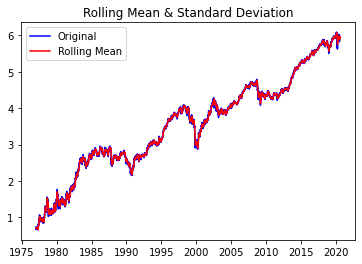

Results of Dickey-Fuller Test:
Test Statistic                    -1.151356
p-value                            0.694164
#Lags Used                        17.000000
Number of Observations Used    10981.000000
Critical Value (1%)               -3.430946
Critical Value (5%)               -2.861803
Critical Value (10%)              -2.566910
dtype: float64


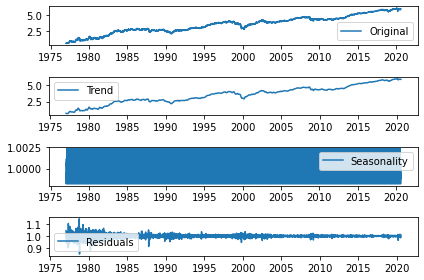

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)

#시계열 분해 (Time Series Decomposition)
decomposition3 = seasonal_decompose(ts3_log, model='multiplicative', period = 30)  #model 선택 이유는?

trend3 = decomposition3.trend
seasonal3 = decomposition3.seasonal
residual3 = decomposition3.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
# Residual 안정성 확인
residual3.dropna(inplace=True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistic                   -22.676160
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10929.000000
Critical Value (1%)               -3.430948
Critical Value (5%)               -2.861804
Critical Value (10%)              -2.566911
dtype: float64


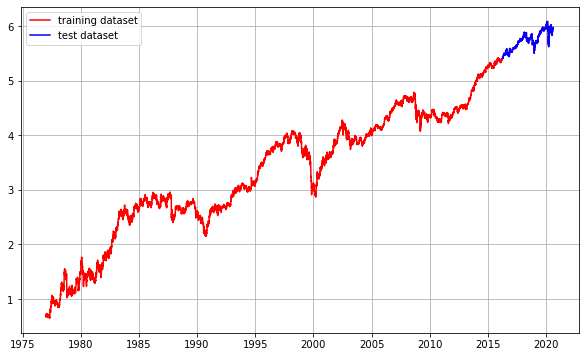

In [28]:
train3_data, test3_data = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')
plt.plot(test3_data, c='b', label='test dataset')
plt.legend()

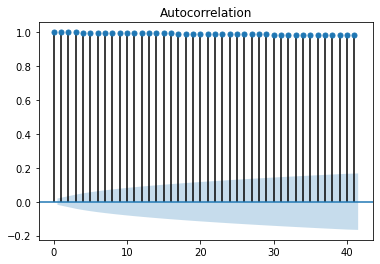

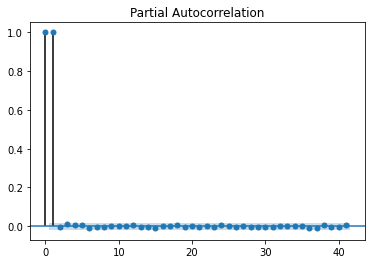

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts3_log)
plot_pacf(ts3_log)
plt.show()
#AR(1)

Results of Dickey-Fuller Test:
Test Statistic                   -24.994496
p-value                            0.000000
#Lags Used                        16.000000
Number of Observations Used    10981.000000
Critical Value (1%)               -3.430946
Critical Value (5%)               -2.861803
Critical Value (10%)              -2.566910
dtype: float64


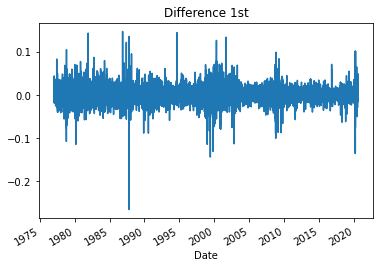

In [30]:
# 차분 안정성 확인

diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1) #p-value 0 -> d = 1

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9898
Model:                 ARIMA(1, 1, 0)   Log Likelihood               25873.555
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 13 Aug 2020   AIC                         -51741.110
Time:                        17:29:46   BIC                         -51719.509
Sample:                             1   HQIC                        -51733.794
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      2.661      0.008       0.000       0.001
ar.L1.D.Close     0.0086      0.010      0.858      0.391      -0.011       0.028
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


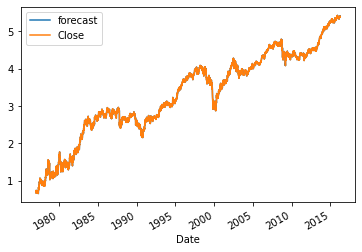

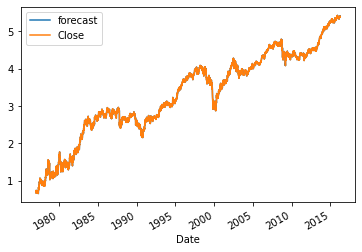

In [31]:
model3 = ARIMA(train3_data, order=(1, 1, 0))  #(p,d,q) p=1, d=1. q값에 따른 큰 차이 없으므로 0으로 선택
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())
fitted_m3.plot_predict() #그래프로 확인

#q값에 따른 MAPE값
#0-8.87
#1-
#2-
#3-
#4-8.90
#5-
#6-
#7-
#8-8.91
#9-
#10-
#11-
#12-8.84

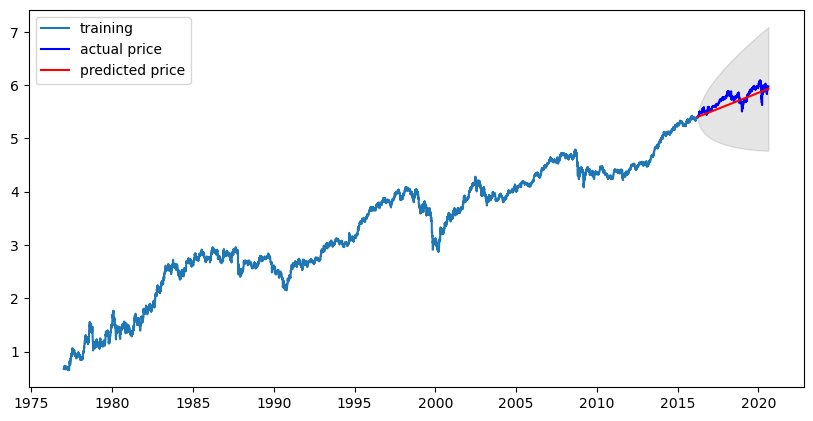

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
fc3, se3, conf3 = fitted_m3.forecast(len(test3_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc3_series = pd.Series(fc3, index=test3_data.index)   # 예측결과
lower3_series = pd.Series(conf3[:, 0], index=test3_data.index)  # 예측결과의 하한 바운드
upper3_series = pd.Series(conf3[:, 1], index=test3_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train3_data, label='training')
plt.plot(test3_data, c='b', label='actual price')
plt.plot(fc3_series, c='r',label='predicted price')
plt.fill_between(lower3_series.index, lower3_series, upper3_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(np.exp(test3_data), np.exp(fc3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test3_data), np.exp(fc3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test3_data), np.exp(fc3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3) - np.exp(test3_data))/np.abs(np.exp(test3_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1204.2666730127526
MAE:  29.028165981557212
RMSE:  34.70254562726995
MAPE: 8.87%


# Conclusion

### 데이터 수집 단계
AMZN(아마존)의 경우 주가 데이터가 존재하는 97년도부터가 아닌 2008년 이후의 데이터를 수집하였다.
2008년 금융위기 이후 아마존의 경영 방침이 변경되며 회사의 변화 양상이 급격히 달라졌기에 2008년을 전후로 다른 회사가 되어 해당년도 이전의 데이터는 의미가 없었기 때문이다.
GOOG(구글)과 LMT(록히드 마틴)의 경우 모든 주가를 수집하였는데 구글의 경우 창립 기간이 짧아 데이터를 선별할 이유가 적었고 록히드 마틴의 경우 록히드가 1995년 마틴 마리에타와 합병해 록히드 마틴이 되는 변화를 겪었으나 창립(1912)부터 현재까지 회사 성격이 동일하기에 1977년 이후 모든 데이터를 수집하였다. 다만 70년대 록히드 마틴의 주가가 센트단위라 달러로 환산하면 소수점이 되는데 로그를 취할경우 음수가 나와 일괄적으로 모든 데이터에 1만큼 더해주었다.

### stationary 판별
각각의 p-value는 0.98, 0.17, 0.69로서 아마존(0.98)과 록히드 마틴(0.69)의 경우 대립가설인 안정적이라고 확정할 수 없지만 분명히 귀무가설을 기각할 수는 없으며 가장 낮은 0.17의 값을 나타낸 구글도 기준인 0.05를 넘기에 마찬가지로 귀무가설을 기각할 수 없다. 따라서 수집한 데이터는 안정적인 시계열이라고 말할 수 없다.

데이터를 multiplicative모델로 분해해서 나온 Residual의 경우 각각 1.44*e-27, 3.50*e-27, 0.00으로 귀무가설을 기각하고 대립가설을 채택, 충분히 안정적인 시계열로 볼 수 있다.

### 하이퍼 파라미터 설정
세 데이터 모두 공통적으로 AR모델에 편중되었으며 p값은 1이고 d값은 1이었다.
q값의 경우 테스트를 통해 변동 폭이 작은 경우와 비교적 큰 경우가 있는데 이는 AR모델에 편중된 정도가 적어 발생한 것으로 아마존의 경우 q값을 달리하여 가장 결과가 좋은 1을 채택하였다.

### MAPE
모델 성능 판정을 위한 기준으로는 MAPE(Mean absolute percentage error)를 선택하였으며 각각 10.79%, 5.04%, 8.87%이었다.